# FashionMNIST classification with Multilayer perceptrons

https://github.com/zalandoresearch/fashion-mnist

# Exercises

1. Try changing the model and training parameters (hidden size, epoch, batch size).
1. Add another hidden layer to the model.
1. All input values are between 0 to 255 (RGB brightness values). Normalize them (scale them to between 0 and 1). You should see a small increase in accuracy.
1. Try standardizing the input values (mean 0, std 1).
1. Implement early stopping. Instead of a fix number of epochs, train until the model stops improving on the dev set. If the dev loss stop decreasing for a few epochs, training should stop.
1. We plot one random sample and its label. Plot a random sample from each class on 10 subplots.
1. Limit printing the loss and the accuracy to every 10th epoch instead of every epoch. 
1. ADVANCED: replace the network with a convolutional neural network. Convolutions should work on 2D images, change the preprocessing steps accordingly. You should see a big increase in accuracy.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchvision import datasets
import torch
import torch.nn as nn
import torch.optim as optim

# Preparing the dataset

## Download and convert to float

In [2]:
train_data = datasets.FashionMNIST('data', download=True, train=True)
# we need FloatTensors as input
train_X = train_data.data.float()
train_y = train_data.targets
test_data = datasets.FashionMNIST('data', download=True, train=False)
test_X = test_data.data.float()
test_y = test_data.targets

## IMPORTANT: Inspect the dataset manually

We will plot a random sample with its labels:

Label: Dress


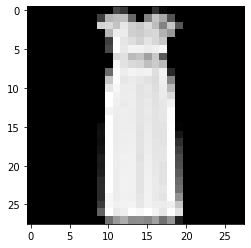

In [3]:
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

idx = np.random.randint(len(train_X))
sample_X = train_X[idx].numpy()
sample_y = train_y[idx].numpy()
print("Label: {}".format(labels[sample_y]))
plt.imshow(sample_X, 'gray')

### Understanding the sizes of the data

Make sure you always understand the output of tensor.size()

Train size X image_x X image_y

In [4]:
train_X.size()

torch.Size([60000, 28, 28])

### Are the classes equally distributed?

In [5]:
np.unique(train_y.numpy(), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

## Flatten images

In [6]:
print("Before flattening:")
print("Train size:", train_X.size(), train_y.size())
print("Test size:", test_X.size(), test_y.size())

train_X = train_X.view(-1, 28 * 28).squeeze(1)
test_X = test_X.view(-1, 28 * 28).squeeze(1)

print("\nAfter flattening:")
print("Train size:", train_X.size(), train_y.size())
print("Test size:", test_X.size(), test_y.size())

Before flattening:
Train size: torch.Size([60000, 28, 28]) torch.Size([60000])
Test size: torch.Size([10000, 28, 28]) torch.Size([10000])

After flattening:
Train size: torch.Size([60000, 784]) torch.Size([60000])
Test size: torch.Size([10000, 784]) torch.Size([10000])


## Splitting the train set into train and dev set

In [7]:
all_idx = np.arange(len(train_X))
np.random.shuffle(all_idx)
train_idx = all_idx[:50000]
dev_idx = all_idx[50000:]
print("The overlap between train and dev should be an empty set:", set(train_idx) & set(dev_idx))
print("")

dev_X = train_X[dev_idx]
dev_y = train_y[dev_idx]
train_X = train_X[train_idx]
train_y = train_y[train_idx]
print("Train size:", train_X.size(), train_y.size())
print("Dev size:", dev_X.size(), dev_y.size())
print("Test size:", test_X.size(), test_y.size())

The overlap between train and dev should be an empty set: set()

Train size: torch.Size([50000, 784]) torch.Size([50000])
Dev size: torch.Size([10000, 784]) torch.Size([10000])
Test size: torch.Size([10000, 784]) torch.Size([10000])


## Helper class that creates minibatches

In [8]:
class BatchedIterator:
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
    
    def iterate_once(self):
        for start in range(0, len(self.X), self.batch_size):
            end = start + self.batch_size
            yield self.X[start:end], self.y[start:end]

Testing the iterator:

In [9]:
train_iter = BatchedIterator(train_X, train_y, 33333)

for batch in train_iter.iterate_once():
    print(batch[0].size(), batch[1].size())

torch.Size([33333, 784]) torch.Size([33333])
torch.Size([16667, 784]) torch.Size([16667])


# Neural network

## Definition

In [10]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, X):
        h = self.input_layer(X)
        h = self.relu(h)
        out = self.output_layer(h)
        return out

## Model instance

In [11]:
model = SimpleClassifier(
    input_dim=train_X.size(1),
    output_dim=10,
    hidden_dim=50
)
model

SimpleClassifier(
  (input_layer): Linear(in_features=784, out_features=50, bias=True)
  (relu): ReLU()
  (output_layer): Linear(in_features=50, out_features=10, bias=True)
)

In [12]:
for n, p in model.named_parameters():
    print(n, p.size())

input_layer.weight torch.Size([50, 784])
input_layer.bias torch.Size([50])
output_layer.weight torch.Size([10, 50])
output_layer.bias torch.Size([10])


## Loss function and optimizer

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

## Sanity check

The model should perform close to random at this point.

**Note** we compute accuracy manually. Make sure you understand it.

In [14]:
test_pred = model(test_X).max(axis=1)[1]
test_acc = torch.eq(test_pred, test_y).sum().float() / len(test_X)
test_acc

tensor(0.1394)

## Training loop

In [15]:
batch_size = 1000
train_iter = BatchedIterator(train_X, train_y, batch_size)
dev_iter = BatchedIterator(dev_X, dev_y, batch_size)
test_iter = BatchedIterator(test_X, test_y, batch_size)

all_train_loss = []
all_dev_loss = []
all_train_acc = []
all_dev_acc = []

n_epochs = 10
for epoch in range(n_epochs):
    # training loop
    for bi, (batch_x, batch_y) in enumerate(train_iter.iterate_once()):
        
        y_out = model(batch_x)
        loss = criterion(y_out, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # one train epoch finished, evaluate on the train and the dev set (NOT the test)
    train_out = model(train_X)
    train_loss = criterion(train_out, train_y)
    all_train_loss.append(train_loss.item())
    train_pred = train_out.max(axis=1)[1]
    train_acc = torch.eq(train_pred, train_y).sum().float() / len(train_X)
    all_train_acc.append(train_acc)
    
    dev_out = model(dev_X)
    dev_loss = criterion(dev_out, dev_y)
    all_dev_loss.append(dev_loss.item())
    dev_pred = dev_out.max(axis=1)[1]
    dev_acc = torch.eq(dev_pred, dev_y).sum().float() / len(dev_X)
    all_dev_acc.append(dev_acc)
    
    print(f"Epoch: {epoch}\n  train accuracy: {train_acc}  train loss: {train_loss}")
    print(f"  dev accuracy: {dev_acc}  dev loss: {dev_loss}")

Epoch: 0
  train accuracy: 0.578220009803772  train loss: 1.2246407270431519
  dev accuracy: 0.5745000243186951  dev loss: 1.2455767393112183
Epoch: 1
  train accuracy: 0.6832600235939026  train loss: 0.8392036557197571
  dev accuracy: 0.677299976348877  dev loss: 0.8747658133506775
Epoch: 2
  train accuracy: 0.7074000239372253  train loss: 0.7486035823822021
  dev accuracy: 0.704800009727478  dev loss: 0.7856230735778809
Epoch: 3
  train accuracy: 0.7379999756813049  train loss: 0.6923190355300903
  dev accuracy: 0.7312999963760376  dev loss: 0.7377351522445679
Epoch: 4
  train accuracy: 0.7712000012397766  train loss: 0.6396324038505554
  dev accuracy: 0.7634000182151794  dev loss: 0.6871625781059265
Epoch: 5
  train accuracy: 0.7843199968338013  train loss: 0.5973774790763855
  dev accuracy: 0.7731000185012817  dev loss: 0.6481789350509644
Epoch: 6
  train accuracy: 0.7934200167655945  train loss: 0.568629264831543
  dev accuracy: 0.7820000052452087  dev loss: 0.6232579350471497
Epo

## Test accuarcy

In [16]:
test_pred = model(test_X).max(axis=1)[1]
test_acc = torch.eq(test_pred, test_y).sum().float() / len(test_X)
test_acc

tensor(0.8001)

## Plot loss functions, accuracies

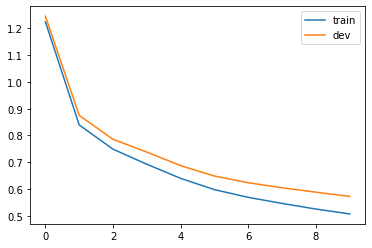

In [17]:
plt.plot(all_train_loss, label='train')
plt.plot(all_dev_loss, label='dev')
plt.legend()

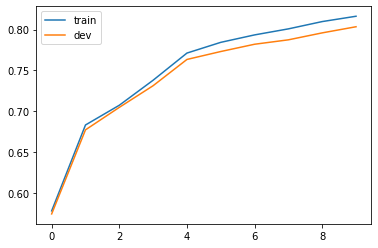

In [18]:
plt.plot(all_train_acc, label='train')
plt.plot(all_dev_acc, label='dev')
plt.legend()

## Overfitting

We'll train a larger network on a much smaller set:

In [19]:
toy_X = train_X[:5]
toy_y = train_y[:5]

model = SimpleClassifier(
    input_dim=train_X.size(1),
    output_dim=10,
    hidden_dim=500
)
optimizer = optim.Adam(model.parameters())

In [20]:
batch_size = 20
toy_train_iter = BatchedIterator(toy_X, toy_y, batch_size)

all_train_loss = []
all_dev_loss = []
all_train_acc = []
all_dev_acc = []

n_epochs = 20
for epoch in range(n_epochs):
    # training loop
    for bi, (batch_x, batch_y) in enumerate(toy_train_iter.iterate_once()):
        
        y_out = model(batch_x)
        loss = criterion(y_out, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # one train epoch finished, evaluate on the train and the dev set (NOT the test)
    train_out = model(toy_X)
    train_loss = criterion(train_out, toy_y)
    all_train_loss.append(train_loss.item())
    train_pred = train_out.max(axis=1)[1]
    train_acc = torch.eq(train_pred, toy_y).sum().float() / len(toy_X)
    all_train_acc.append(train_acc)
    
    dev_out = model(dev_X)
    dev_loss = criterion(dev_out, dev_y)
    all_dev_loss.append(dev_loss.item())
    dev_pred = dev_out.max(axis=1)[1]
    dev_acc = torch.eq(dev_pred, dev_y).sum().float() / len(dev_X)
    all_dev_acc.append(dev_acc)

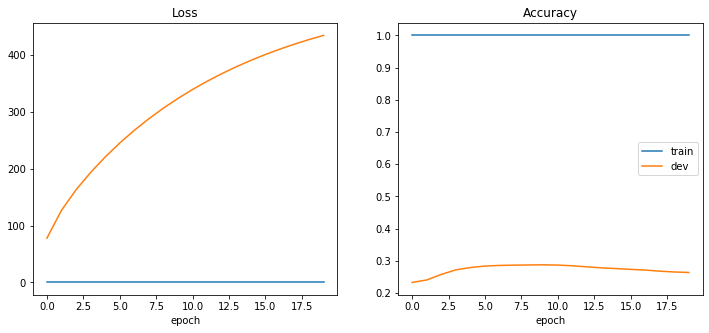

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].set_title("Loss")
ax[1].set_title("Accuracy")
ax[0].set_xlabel("epoch")
ax[1].set_xlabel("epoch")
ax[0].plot(all_train_loss, label='train')
ax[0].plot(all_dev_loss, label='dev')
ax[1].plot(all_train_acc, label='train')
ax[1].plot(all_dev_acc, label='dev')
plt.legend()

# Gotchas

## List elements are not trained

Modules such as `nn.Linear` are not registered as parameters if they're not direct attributes of a module.

In this example we add two extra layers as a list to the module:

In [22]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, output_dim,
                 hidden_dim):
        super().__init__()
        self.input_layer = nn.Linear(
            input_dim, hidden_dim)
        
        # let's add some extra layers in a list
        self.extra_layers = [
            nn.Linear(hidden_dim, 100),
            nn.ReLU(),
            nn.Linear(100, hidden_dim),
            nn.ReLU(),
        ]
        
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(
            hidden_dim, output_dim)
        
    def forward(self, X):
        h = self.input_layer(X)
        h = self.relu(h)
        # passing through extra layers
        for layer in self.extra_layers:
            h = layer(h)
        out = self.output_layer(h)
        return out

they are not part of the model

In [23]:
m = SimpleClassifier(4, 5, 6)
print(m)

print("Parameters:")
for name, param in m.named_parameters():
    print("Name: {}, size: {}".format(name, param.size()))

SimpleClassifier(
  (input_layer): Linear(in_features=4, out_features=6, bias=True)
  (relu): ReLU()
  (output_layer): Linear(in_features=6, out_features=5, bias=True)
)
Parameters:
Name: input_layer.weight, size: torch.Size([6, 4])
Name: input_layer.bias, size: torch.Size([6])
Name: output_layer.weight, size: torch.Size([5, 6])
Name: output_layer.bias, size: torch.Size([5])


## One solution is `nn.ModuleList`

In [24]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, output_dim,
                 hidden_dim):
        super().__init__()
        self.input_layer = nn.Linear(
            input_dim, hidden_dim)
        
        # use ModuleList
        self.extra_layers = nn.ModuleList([
            nn.Linear(hidden_dim, 100),
            nn.ReLU(),
            nn.Linear(100, hidden_dim),
            nn.ReLU(),
        ])
        
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(
            hidden_dim, output_dim)
        
    def forward(self, X):
        h = self.input_layer(X)
        h = self.relu(h)
        # passing through extra layers
        for layer in self.extra_layers:
            h = layer(h)
        out = self.output_layer(h)
        return out

In [25]:
m = SimpleClassifier(4, 5, 6)
print(m)

print("Parameters:")
for name, param in m.named_parameters():
    print("Name: {}, size: {}".format(name, param.size()))

SimpleClassifier(
  (input_layer): Linear(in_features=4, out_features=6, bias=True)
  (extra_layers): ModuleList(
    (0): Linear(in_features=6, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=6, bias=True)
    (3): ReLU()
  )
  (relu): ReLU()
  (output_layer): Linear(in_features=6, out_features=5, bias=True)
)
Parameters:
Name: input_layer.weight, size: torch.Size([6, 4])
Name: input_layer.bias, size: torch.Size([6])
Name: extra_layers.0.weight, size: torch.Size([100, 6])
Name: extra_layers.0.bias, size: torch.Size([100])
Name: extra_layers.2.weight, size: torch.Size([6, 100])
Name: extra_layers.2.bias, size: torch.Size([6])
Name: output_layer.weight, size: torch.Size([5, 6])
Name: output_layer.bias, size: torch.Size([5])


# Using the GPU

In [26]:
use_cuda = torch.cuda.is_available()
print(use_cuda)

False


Moving things manually to the GPU:

1. model: move once
1. criterion: move once
1. data: move one batch at a time

This should be automatically handled by your code the following way:

In [27]:
if use_cuda:
    model = model.cuda()
    criterion = criterion.cuda()